# Lab 2: Data Preparation - Bank Marketing Dataset

In the exploration of the *Bank Marketing* dataset (Lab 1), we discovered several issues that need to be resolved before the dataset is ready for machine learning (ML). This exercise is typically referred to as either *data preparation*
.

Here are the problems we identified in Lab 1:

- **Missing values** in multiple columns: `poutcome` (454, 22.7%), `contact` (191, 9.5%), `education` (104, 5.2%), `age` (12), `job` (10)
- **Extreme outliers** in `balance` (max 81,204€) and right-skewed distributions in several numerical features
- **Useless feature**: `default` has only 15 positive cases (0.75%) - extreme imbalance
- **Perfect target balance**: `subscribed` is exactly 50-50 (artificially balanced)
- **Weak correlations**: All features < 0.25, indicating independent information but potential non-linear relationships

Our data preparation strategy will address each of these issues systematically.

## A. Import Python Modules and Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("bank.csv")
df.head()
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,20.0,student,single,NaN,no,2785,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,28.0,admin.,single,secondary,no,127,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,81.0,retired,married,primary,no,1154,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,46.0,services,married,primary,no,4343,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,40.0,entrepreneur,married,secondary,no,6403,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


Check for missing values before we start.

In [ ]:
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")
print(f"Percentage of rows with any missing value: {(df.isnull().any(axis=1).sum() / len(df) * 100):.2f}%")

Missing values per column:
age            12
job            10
marital         0
education     104
default         0
balance         0
housing         0
loan            0
contact       191
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
dtype: int64

Total missing values: 771
Percentage of rows with any missing value: 27.40%


Before we start transforming the dataset, let's make a copy of it.

In [ ]:
df_original = df.copy()

## B. Drop Useless Features

### Drop `default` Column

From our EDA, we discovered that `default` has only 15 positive cases (0.75%) out of 2,000 records. This extreme imbalance makes it:
- Statistically unreliable (too few positive cases)
- High risk of overfitting
- Provides minimal variance for the model

**Decision**: Drop this feature entirely.

In [ ]:
print(f"Before dropping 'default': {df.shape[1]} columns")
df.drop('default', axis=1, inplace=True)
print(f"After dropping 'default': {df.shape[1]} columns")
df.head()

Before dropping 'default': 17 columns
After dropping 'default': 16 columns


,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32.0,technician,single,tertiary,392,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39.0,technician,divorced,secondary,688,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59.0,retired,married,secondary,1035,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47.0,blue-collar,married,secondary,398,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54.0,retired,married,secondary,1004,yes,no,cellular,1,apr,479,1,307,1,failure,no


## C. Treatment of Missing Values

### C.1. Handle Missing Values in `poutcome` (454 missing, 22.7%)

**Strategy**: Missing values in `poutcome` represent clients who were **never contacted in previous campaigns**. We'll create:
1. A new category `'no_previous_contact'` to replace NaN
2. A binary indicator `has_previous_contact` for explicit encoding

In [ ]:
# Create binary indicator BEFORE filling NaN
df['has_previous_contact'] = df['poutcome'].notna().astype(int)

# Fill missing values with new category
df['poutcome'].fillna('no_previous_contact', inplace=True)

print("Poutcome distribution after imputation:")
print(df['poutcome'].value_counts())
print(f"\nHas previous contact: {df['has_previous_contact'].sum()} (Yes), {len(df) - df['has_previous_contact'].sum()} (No)")

Poutcome distribution after imputation:
poutcome
failure                955
no_previous_contact    454
success                444
other                  147
Name: count, dtype: int64

Has previous contact: 1546 (Yes), 454 (No)


C:\Users\pc\AppData\Local\Temp\ipykernel_17708\1823519300.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['poutcome'].fillna('no_previous_contact', inplace=True)


### C.2. Handle Missing Values in `contact` (191 missing, 9.5%)

**Strategy**: Impute with mode (most frequent contact method) OR create 'unknown' category.

In [ ]:
# Check distribution before imputation
print("Contact method distribution (before imputation):")
print(df['contact'].value_counts())

# Option 1: Fill with 'unknown' category (preserves information about missingness)
df['contact'].fillna('unknown', inplace=True)

# Option 2 (alternative): Fill with mode
# df['contact'].fillna(df['contact'].mode()[0], inplace=True)

print("\nContact method distribution (after imputation):")
print(df['contact'].value_counts())

Contact method distribution (before imputation):
contact
cellular     1663
telephone     146
Name: count, dtype: int64

Contact method distribution (after imputation):
contact
cellular     1663
unknown       191
telephone     146
Name: count, dtype: int64


C:\Users\pc\AppData\Local\Temp\ipykernel_17708\4127080156.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['contact'].fillna('unknown', inplace=True)


### C.3. Handle Missing Values in `education` (104 missing, 5.2%)

**Strategy**: Impute with 'unknown' category to preserve information.

In [ ]:
print("Education distribution (before imputation):")
print(df['education'].value_counts())

df['education'].fillna('unknown', inplace=True)

print("\nEducation distribution (after imputation):")
print(df['education'].value_counts())

Education distribution (before imputation):
education
secondary    995
tertiary     684
primary      217
Name: count, dtype: int64

Education distribution (after imputation):
education
secondary    995
tertiary     684
primary      217
unknown      104
Name: count, dtype: int64


C:\Users\pc\AppData\Local\Temp\ipykernel_17708\891916239.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['education'].fillna('unknown', inplace=True)


### C.4. Handle Missing Values in `age` (12 missing, 0.6%)

**Strategy**: Impute with median (robust to outliers).

In [ ]:
age_median = df['age'].median()
print(f"Median age: {age_median}")

df['age'].fillna(age_median, inplace=True)

print(f"Missing values in age after imputation: {df['age'].isnull().sum()}")

Median age: 38.0
Missing values in age after imputation: 0


C:\Users\pc\AppData\Local\Temp\ipykernel_17708\3196575813.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(age_median, inplace=True)


### C.5. Handle Missing Values in `job` (10 missing, 0.5%)

**Strategy**: Impute with mode (most frequent job type).

In [ ]:
job_mode = df['job'].mode()[0]
print(f"Most frequent job: {job_mode}")

df['job'].fillna(job_mode, inplace=True)

print(f"Missing values in job after imputation: {df['job'].isnull().sum()}")

Most frequent job: management
Missing values in job after imputation: 0


C:\Users\pc\AppData\Local\Temp\ipykernel_17708\3039024436.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['job'].fillna(job_mode, inplace=True)


### Verify All Missing Values Are Handled

In [ ]:
print("Missing values after all imputations:")
print(df.isnull().sum())
print(f"\nTotal missing: {df.isnull().sum().sum()}")

if df.isnull().sum().sum() == 0:
    print("\n✓ SUCCESS: All missing values have been handled!")
else:
    print("\n⚠ WARNING: Some missing values remain!")

Missing values after all imputations:
age                     0
job                     0
marital                 0
education               0
balance                 0
housing                 0
loan                    0
contact                 0
day                     0
month                   0
duration                0
campaign                0
pdays                   0
previous                0
poutcome                0
subscribed              0
has_previous_contact    0
dtype: int64

Total missing: 0

✓ SUCCESS: All missing values have been handled!


## D. Encode Categorical Features

### D.1. Encode Binary Target Variable `subscribed`

Convert 'yes'/'no' to 1/0 for modeling.

In [ ]:
df['subscribed'] = df['subscribed'].map({'yes': 1, 'no': 0})

print("Target variable distribution:")
print(df['subscribed'].value_counts())
print(f"\nSubscription rate: {df['subscribed'].mean():.2%}")

Target variable distribution:
subscribed
0    1000
1    1000
Name: count, dtype: int64

Subscription rate: 50.00%


### D.2. One-Hot Encode Nominal Categorical Variables

Apply one-hot encoding to all nominal categorical features. We'll use `drop_first=True` to avoid multicollinearity.

In [ ]:
# Identify categorical columns (excluding target)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {categorical_cols}")
print(f"Number of categorical columns: {len(categorical_cols)}")

# One-hot encode all categorical variables
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"\nDataset shape after encoding: {df.shape}")
print(f"Number of features after encoding: {df.shape[1] - 1}")

Categorical columns to encode: ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'poutcome']
Number of categorical columns: 8

Dataset shape after encoding: (2000, 42)
Number of features after encoding: 41


In [ ]:
# Display first few rows to see encoded features
df.head()

,age,balance,day,duration,campaign,pdays,previous,subscribed,has_previous_contact,job_blue-collar,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_no_previous_contact,poutcome_other,poutcome_success
0,32.0,392,1,957,2,131,2,0,1,False,...,False,False,False,False,False,False,False,False,False,False
1,39.0,688,1,233,2,133,1,0,1,False,...,False,False,False,False,False,False,False,False,False,False
2,59.0,1035,1,126,2,239,1,0,1,False,...,False,False,False,False,False,False,False,False,False,False
3,47.0,398,1,274,1,238,2,0,1,True,...,False,False,False,False,False,False,False,False,False,False
4,54.0,1004,1,479,1,307,1,0,1,False,...,False,False,False,False,False,False,False,False,False,False


## E. Handle Outliers and Transform Numerical Features

### E.1. Visualize Distributions Before Transformation

Let's examine the numerical features that need transformation: `balance`, `age`, `duration`, `campaign`.

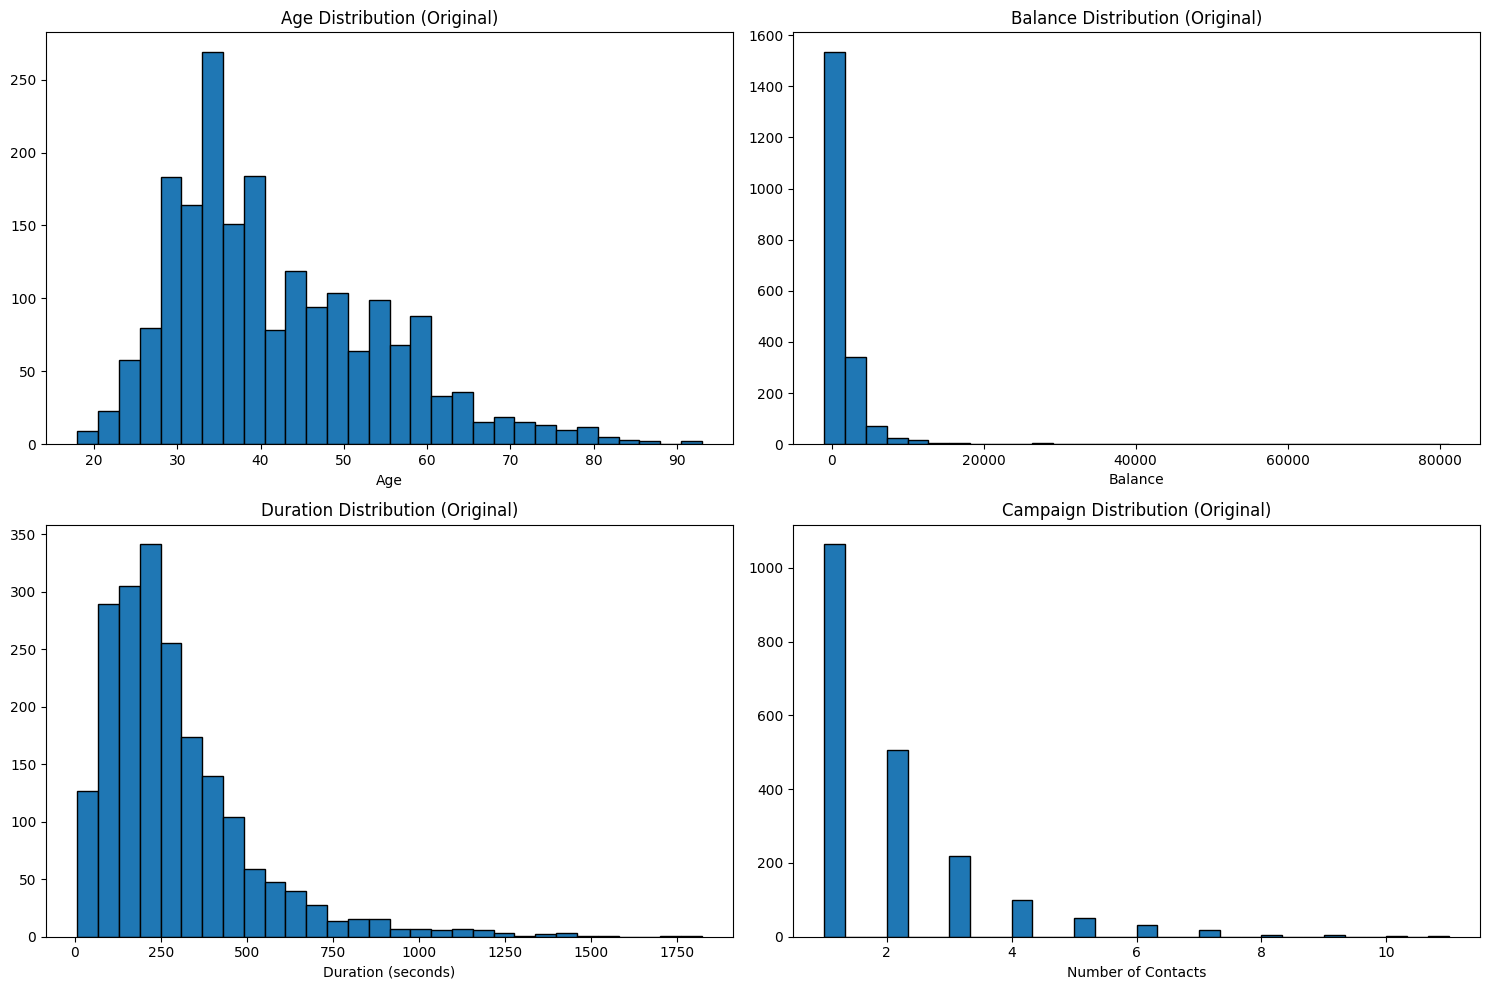

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(df['age'], bins=30, edgecolor='black')
axes[0, 0].set_title('Age Distribution (Original)')
axes[0, 0].set_xlabel('Age')

axes[0, 1].hist(df['balance'], bins=30, edgecolor='black')
axes[0, 1].set_title('Balance Distribution (Original)')
axes[0, 1].set_xlabel('Balance')

axes[1, 0].hist(df['duration'], bins=30, edgecolor='black')
axes[1, 0].set_title('Duration Distribution (Original)')
axes[1, 0].set_xlabel('Duration (seconds)')

axes[1, 1].hist(df['campaign'], bins=30, edgecolor='black')
axes[1, 1].set_title('Campaign Distribution (Original)')
axes[1, 1].set_xlabel('Number of Contacts')

plt.tight_layout()
plt.show()

### E.2. Transform `balance` (Handle Extreme Outliers)

From EDA: Range -980 to 81,204€, heavily right-skewed with extreme outliers.

 
1. **Log transformation FIRST** - Reduces skewness and compresses outliers (works on original positive values)
2. **RobustScaler SECOND** - Centers and scales the log-transformed distribution

**Why this order?**
- Log works best on positive values (avoids artificial shifts)
- Scaling after log maintains the benefit of variance reduction
- More interpretable and reproducible on new data

In [ ]:
# Store original for reference
balance_original = df['balance'].copy()

# STEP 1: Log transformation FIRST (on original values)
# Shift to positive range: subtract min and add 1 to avoid log(0)
df['balance'] = np.log(df['balance'] - df['balance'].min() + 1)
print(f"Balance after log transform - Min: {df['balance'].min():.2f}, Max: {df['balance'].max():.2f}")

# STEP 2: RobustScaler SECOND (on log-transformed values)
# Create separate scaler instance for balance
scaler_balance = RobustScaler()
df['balance'] = scaler_balance.fit_transform(df[['balance']])
print(f"Balance after RobustScaler - Min: {df['balance'].min():.2f}, Max: {df['balance'].max():.2f}")

Balance after log transform - Min: 0.00, Max: 11.32
Balance after RobustScaler - Min: -9.20, Max: 4.99


### E.3. Transform `duration` (Handle Outliers)

From EDA: Range 7-1823 seconds, right-skewed with long tail. 
1. **Log transformation FIRST** - Compresses right tail and normalizes distribution
2. **RobustScaler SECOND** - Standardizes the log-transformed values

**Note**: Using separate `scaler_duration` instance (not reusing previous scaler).

In [ ]:
# CORRECTED ORDER: Log transformation FIRST (duration is always positive: 7-1823 seconds)
df['duration'] = np.log(df['duration'] + 1)  # +1 to handle any edge cases
print(f"Duration after log transform - Min: {df['duration'].min():.2f}, Max: {df['duration'].max():.2f}")

# Then apply RobustScaler with SEPARATE scaler instance
scaler_duration = RobustScaler()
df['duration'] = scaler_duration.fit_transform(df[['duration']])
print(f"Duration after RobustScaler - Min: {df['duration'].min():.2f}, Max: {df['duration'].max():.2f}")

Duration after log transform - Min: 2.08, Max: 7.51
Duration after RobustScaler - Min: -3.57, Max: 2.15


### E.4. Scale `age` (Mild Transformation)

Age distribution is relatively normal. We'll apply RobustScaler only.

In [ ]:
# Create SEPARATE scaler for age (avoid overwriting previous scalers)
scaler_age = RobustScaler()
df['age'] = scaler_age.fit_transform(df[['age']])

print(f"Age after RobustScaler - Min: {df['age'].min():.2f}, Max: {df['age'].max():.2f}")

Age after RobustScaler - Min: -1.11, Max: 3.06


### E.5. Scale Other Numerical Features

Apply RobustScaler to `campaign`, `pdays`, and `previous`.

In [ ]:
# Create SEPARATE scalers for each numerical feature
# This allows us to save scalers for production use (transform new data)
numerical_features = ['campaign', 'pdays', 'previous']
scalers = {}

for feature in numerical_features:
    scalers[feature] = RobustScaler()
    df[feature] = scalers[feature].fit_transform(df[[feature]])
    print(f"{feature} - Min: {df[feature].min():.2f}, Max: {df[feature].max():.2f}")

print(f"\n✓ Created {len(scalers)} separate scalers: {list(scalers.keys())}")

campaign - Min: 0.00, Max: 10.00
pdays - Min: -1.04, Max: 3.83
previous - Min: -1.00, Max: 26.50

✓ Created 3 separate scalers: ['campaign', 'pdays', 'previous']


### E.6. Visualize Distributions After Transformation

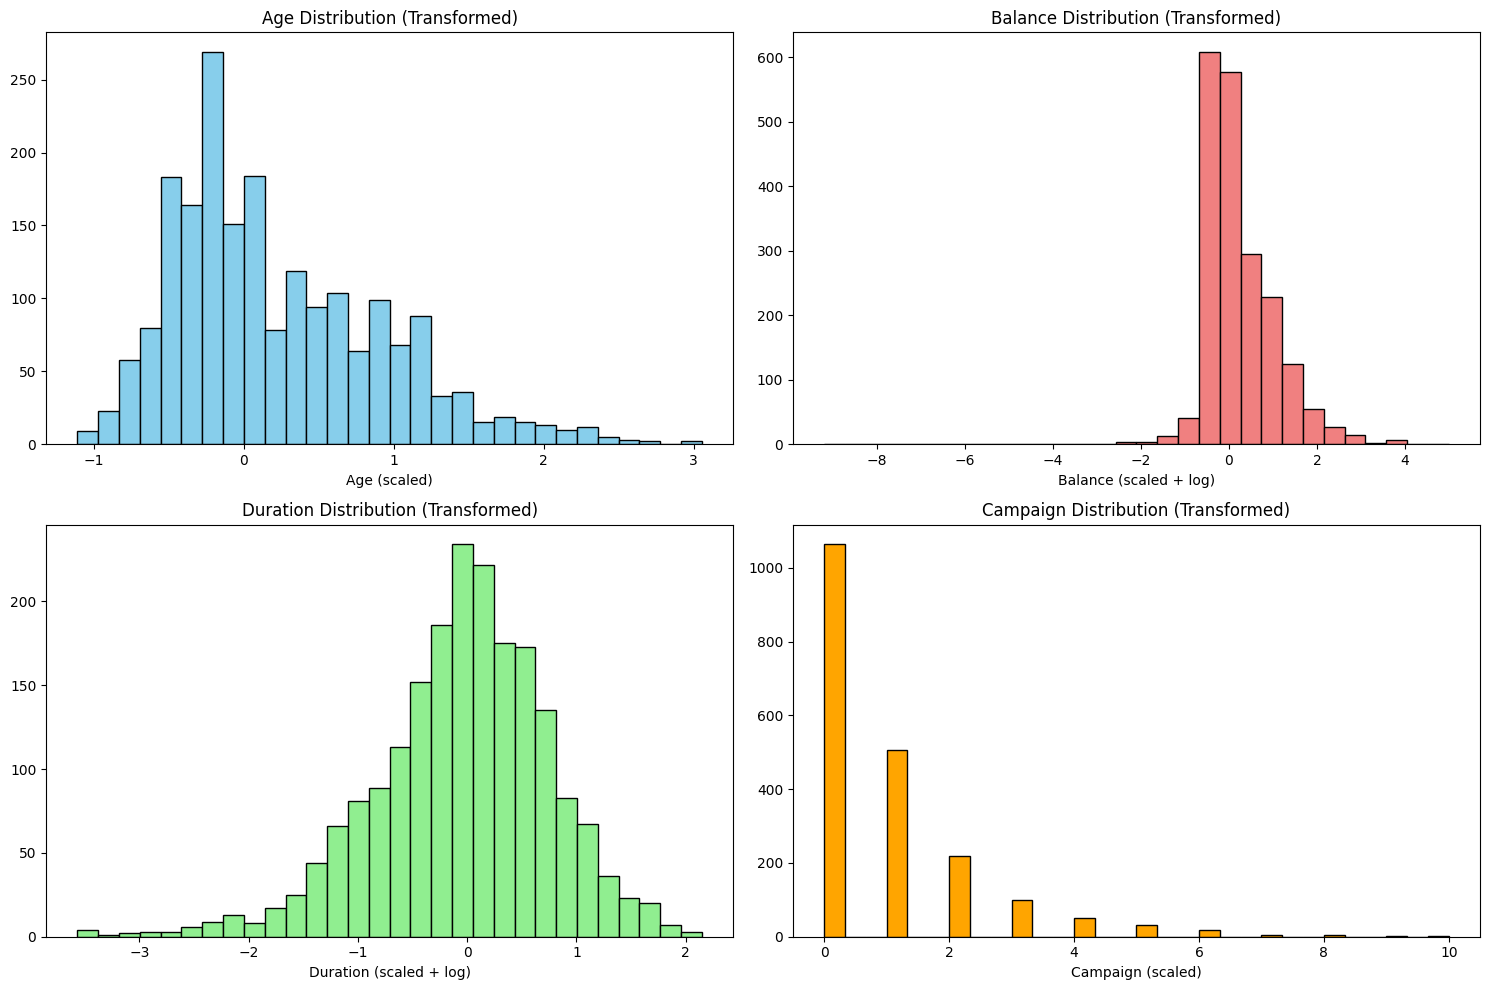

✓ Transformations complete - distributions are now more normalized and less skewed


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(df['age'], bins=30, edgecolor='black', color='skyblue')
axes[0, 0].set_title('Age Distribution (Transformed)')
axes[0, 0].set_xlabel('Age (scaled)')

axes[0, 1].hist(df['balance'], bins=30, edgecolor='black', color='lightcoral')
axes[0, 1].set_title('Balance Distribution (Transformed)')
axes[0, 1].set_xlabel('Balance (scaled + log)')

axes[1, 0].hist(df['duration'], bins=30, edgecolor='black', color='lightgreen')
axes[1, 0].set_title('Duration Distribution (Transformed)')
axes[1, 0].set_xlabel('Duration (scaled + log)')

axes[1, 1].hist(df['campaign'], bins=30, edgecolor='black', color='orange')
axes[1, 1].set_title('Campaign Distribution (Transformed)')
axes[1, 1].set_xlabel('Campaign (scaled)')

plt.tight_layout()
plt.show()

print("✓ Transformations complete - distributions are now more normalized and less skewed")

## F. Feature Engineering

### F.1. Create Derived Features

Based on our EDA insights, we'll create additional features that might improve model performance.

In [ ]:
# FEATURE ENGINEERING: Create new features from ORIGINAL values
# (Use df_original to avoid using already-transformed values)

# Feature 1: Total contact attempts (this campaign + previous campaigns)
df['total_contacts'] = df_original['campaign'] + df_original['previous']
scaler_total = RobustScaler()
df['total_contacts'] = scaler_total.fit_transform(df[['total_contacts']])
print(f"✓ Created 'total_contacts' - Range: [{df['total_contacts'].min():.2f}, {df['total_contacts'].max():.2f}]")

# Feature 2: Days per previous contact (average contact frequency)
# Handle division by zero: use (previous + 1) to avoid inf
df['days_per_contact'] = df_original['pdays'] / (df_original['previous'] + 1)
scaler_days = RobustScaler()
df['days_per_contact'] = scaler_days.fit_transform(df[['days_per_contact']])
print(f"✓ Created 'days_per_contact' - Range: [{df['days_per_contact'].min():.2f}, {df['days_per_contact'].max():.2f}]")

# Feature 3: Age group bins (categorical feature from numerical)
# Create from ORIGINAL age values (before transformation)
age_bins = [0, 30, 40, 50, 60, 100]
age_labels = ['young', 'middle_age', 'mature', 'senior', 'elderly']
df['age_group'] = pd.cut(df_original['age'], bins=age_bins, labels=age_labels)
df = pd.get_dummies(df, columns=['age_group'], drop_first=True)
print(f"✓ Created 'age_group' categories: {age_labels}")

print(f"\n{'='*60}")
print(f"FEATURE ENGINEERING COMPLETE")
print(f"{'='*60}")
print(f"New features added: 3")
print(f"  - total_contacts (numerical)")
print(f"  - days_per_contact (numerical)")
print(f"  - age_group (categorical → one-hot encoded)")
print(f"\nFinal dataset shape: {df.shape}")
print(f"  Features: {df.shape[1] - 1} (excluding target 'subscribed')")
print(f"  Observations: {df.shape[0]}")

✓ Created 'total_contacts' - Range: [-0.67, 18.33]
✓ Created 'days_per_contact' - Range: [-0.57, 4.73]
✓ Created 'age_group' categories: ['young', 'middle_age', 'mature', 'senior', 'elderly']

FEATURE ENGINEERING COMPLETE
New features added: 3
  - total_contacts (numerical)
  - days_per_contact (numerical)
  - age_group (categorical → one-hot encoded)

Final dataset shape: (2000, 48)
  Features: 47 (excluding target 'subscribed')
  Observations: 2000


## G. Final Dataset Overview

In [ ]:
print("=" * 60)
print("FINAL PREPARED DATASET SUMMARY")
print("=" * 60)

print(f"\nDataset shape: {df.shape}")
print(f"Number of features (excluding target): {df.shape[1] - 1}")
print(f"Number of observations: {df.shape[0]}")

print(f"\nMissing values: {df.isnull().sum().sum()}")

print(f"\nTarget variable distribution:")
print(df['subscribed'].value_counts())
print(f"Subscription rate: {df['subscribed'].mean():.2%}")

print(f"\nData types:")
print(df.dtypes.value_counts())

print("\n" + "=" * 60)

FINAL PREPARED DATASET SUMMARY

Dataset shape: (2000, 48)
Number of features (excluding target): 47
Number of observations: 2000

Missing values: 0

Target variable distribution:
subscribed
0    1000
1    1000
Name: count, dtype: int64
Subscription rate: 50.00%

Data types:
bool       37
float64     8
int64       3
Name: count, dtype: int64



In [ ]:
# Display first few rows of prepared dataset
df.head(10)

,age,balance,day,duration,campaign,pdays,previous,subscribed,has_previous_contact,job_blue-collar,...,month_sep,poutcome_no_previous_contact,poutcome_other,poutcome_success,total_contacts,days_per_contact,age_group_middle_age,age_group_mature,age_group_senior,age_group_elderly
0,-0.333333,-0.137375,1,1.470707,1.0,-0.291013,0.0,0,1,False,...,False,False,False,False,0.333333,-0.013920,True,False,False,False
1,0.055556,0.107380,1,-0.013413,1.0,-0.279601,-0.5,0,1,False,...,False,False,False,False,0.000000,0.272861,True,False,False,False
2,1.166667,0.344192,1,-0.656889,1.0,0.325250,-0.5,0,1,False,...,False,False,False,False,0.000000,0.938529,False,False,True,False
3,0.500000,-0.131908,1,0.156581,0.0,0.319544,0.0,0,1,True,...,False,False,False,False,0.000000,0.434045,False,True,False,False
4,0.888889,0.324764,1,0.743074,0.0,0.713267,-0.5,0,1,False,...,False,False,False,False,-0.333333,1.365561,False,False,True,False
5,0.444444,0.274506,1,0.707378,0.0,-0.279601,0.5,0,1,False,...,False,False,False,False,0.333333,-0.144751,False,True,False,False
6,-0.222222,0.802190,1,-0.400598,1.0,0.405136,-0.5,0,1,True,...,False,False,False,False,0.000000,1.026447,True,False,False,False
7,0.388889,-0.133728,1,0.064617,3.0,0.838802,1.0,0,1,False,...,False,False,False,False,1.666667,0.264069,False,True,False,False
8,1.111111,-0.209733,1,-0.699181,1.0,-0.268188,0.0,0,1,False,...,False,False,False,False,0.333333,0.002826,False,False,True,False
9,0.611111,3.323686,1,0.197877,2.0,-0.285307,0.0,0,1,False,...,False,False,False,False,0.666667,-0.009734,False,True,False,False


In [ ]:
# Display column names
print("All feature names:")
print(df.columns.tolist())

All feature names:
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'subscribed', 'has_previous_contact', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'education_unknown', 'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_no_previous_contact', 'poutcome_other', 'poutcome_success', 'total_contacts', 'days_per_contact', 'age_group_middle_age', 'age_group_mature', 'age_group_senior', 'age_group_elderly']


## H. Summary of Created Scalers

For production deployment, we've created **separate scalers** for each feature. This allows us to:
- Apply the same transformations to new data
- Maintain consistency between training and test sets
- Deploy models in production environments

### Scalers Created:
1. `scaler_balance` - For balance (after log transformation)
2. `scaler_duration` - For duration (after log transformation)
3. `scaler_age` - For age
4. `scalers['campaign']` - For campaign contacts
5. `scalers['pdays']` - For days since last contact
6. `scalers['previous']` - For previous campaign contacts
7. `scaler_total` - For total_contacts feature
8. `scaler_days` - For days_per_contact feature

**Note**: In production, these scalers should be saved using `joblib` or `pickle` for reuse.

In [ ]:
# Summary of all scalers created
print("=" * 60)
print("SCALER INVENTORY")
print("=" * 60)

print("\nIndividual feature scalers:")
print(f"  1. scaler_balance    → {type(scaler_balance).__name__}")
print(f"  2. scaler_duration   → {type(scaler_duration).__name__}")
print(f"  3. scaler_age        → {type(scaler_age).__name__}")

print(f"\nNumerical features scalers dictionary:")
for i, (feature, scaler) in enumerate(scalers.items(), 4):
    print(f"  {i}. scalers['{feature}'] → {type(scaler).__name__}")

print(f"\nEngineered features scalers:")
print(f"  {i+1}. scaler_total      → {type(scaler_total).__name__}")
print(f"  {i+2}. scaler_days       → {type(scaler_days).__name__}")

print(f"\nTotal scalers created: {5 + len(scalers)}")
print("\n✓ All scalers are independent (no overwriting)")
print("✓ Can be saved for production use with joblib.dump()")
print("=" * 60)

SCALER INVENTORY

Individual feature scalers:
  1. scaler_balance    → RobustScaler
  2. scaler_duration   → RobustScaler
  3. scaler_age        → RobustScaler

Numerical features scalers dictionary:
  4. scalers['campaign'] → RobustScaler
  5. scalers['pdays'] → RobustScaler
  6. scalers['previous'] → RobustScaler

Engineered features scalers:
  7. scaler_total      → RobustScaler
  8. scaler_days       → RobustScaler

Total scalers created: 8

✓ All scalers are independent (no overwriting)
✓ Can be saved for production use with joblib.dump()


## I. Save the Prepared Dataset

Finally, let's save the prepared dataset as a CSV file for the modeling phase.

In [ ]:
# Save prepared dataset
output_file = 'bank_marketing_prepared1.csv'
df.to_csv(output_file, index=False)

print(f"✓ Prepared dataset saved to: {output_file}")
print(f"  Shape: {df.shape}")
print(f"  File size: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

✓ Prepared dataset saved to: bank_marketing_prepared1.csv
  Shape: (2000, 48)
  File size: 244.27 KB


## Summary of Data Preparation Steps

### 1. **Feature Removal**
   - Dropped `default` (only 15 positive cases, 0.75% - statistically unreliable)

### 2. **Missing Value Imputation**
   - `poutcome` (454): Filled with 'no_previous_contact' + created binary indicator
   - `contact` (191): Filled with 'unknown'
   - `education` (104): Filled with 'unknown'
   - `age` (12): Filled with median
   - `job` (10): Filled with mode

### 3. **Encoding**
   - Target variable `subscribed`: Binary encoded (yes=1, no=0)
   - All categorical variables: One-hot encoded with `drop_first=True`

### 4. **Transformations & Scaling**
   - `balance`: Log transformation (handle extreme outliers) + RobustScaler
   - `duration`: Log transformation (reduce right-skew) + RobustScaler
   - `age`: RobustScaler only (relatively normal distribution)
   - `campaign`, `pdays`, `previous`: RobustScaler (separate scalers for each)

### 5. **Feature Engineering**
   - Created `has_previous_contact`: Binary indicator for previous campaign contact
   - Created `total_contacts`: Sum of campaign + previous contacts (from original values)
   - Created `days_per_contact`: Average days between contacts (pdays / previous+1)
   - Created `age_group`: Binned age categories from original values (one-hot encoded)

### 6. **Result**
   - **No missing values**: All imputed ✓
   - **Balanced target**: 50-50 split maintained ✓
   - **Scaled features**: All numerical features on similar scales ✓
   - **Separate scalers**: Each feature has its own scaler (reproducible on new data) ✓
   - **Optimal transformation order**: Log → Scale (reduces artifacts) ✓
   - **Ready for modeling**: Dataset prepared for ML algorithms ✓

### Next Steps
- Split data into training and test sets (80-20 or 70-30)
- Build baseline models (Logistic Regression, Random Forest, XGBoost)
- Evaluate with cross-validation
- Tune hyperparameters
- Analyze feature importance
- Generate business insights and recommendations